In [2]:
from class_SEIR import SEIR
import numpy as np
import matplotlib.pyplot as plt
import importlib
import sys
from scipy.integrate import odeint

In [3]:
def plot_all_states(S, E, I, R, dim):
    """
        dim: dimension of the mobility matrix
    
    """
    plt.subplot(2,2,1)
    #Plot all Susceptible
    for i in range(dim):
        plt.plot(S[i])

    plt.title("Susceptible")
    plt.ylabel("Person")

    plt.subplot(2,2,2)
    #Plot all Exposed
    for i in range(dim):
        plt.plot(E[i])

    plt.title("Exposed")  

    plt.subplot(2,2,3)
    #Plot all Infected
    for i in range(dim):
        plt.plot(I[i])

    plt.title("Infected")
    plt.ylabel("Person")
    plt.xlabel("Time")  

    plt.subplot(2,2,4)
    #Plot all Removed
    for i in range(dim):
        plt.plot(R[i])

    plt.title("Removed")
    plt.xlabel("Time")

    plt.show()

def plot_comparison(dim_system, test_syn, I_single, E_single, I0_sum, E0_sum):
    plt.rcParams["figure.figsize"] = 14, 10

    plt.subplot(2,2,1)
    for i in range(dim_system):
        plt.plot(t,test_syn.I[i][:-1], label='Infected nodes {}'.format(i))

    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Infected, SEIR* model, {} nodes".format(dim_system))
    plt.legend()

    plt.subplot(2,2,2)
    for i in range(dim_system):
        plt.plot(t,test_syn.E[i][:-1], label='Exposed nodes {}'.format(i))

    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Exposed, SEIR* model, {} nodes".format(dim_system))
    plt.legend()

    plt.subplot(2,2,3)
    plt.plot(t, I_single, label='Infected single')
    plt.plot(t, I0_sum[:-1], label='Infected sum {} nodes'.format(dim_system))
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Infected, SEIR/SEIR* comparison")
    plt.legend()

    plt.subplot(2,2,4)
    plt.plot(t, E_single, label='Exposed single')
    plt.plot(t, E0_sum[:-1], label='Exposed sum {} nodes'.format(dim_system))
    plt.xlabel('Days')
    plt.ylabel('Population')
    plt.title("Exposed, SEIR/SEIR* comparison")
    plt.legend()

    plt.show()
    
#SEIR model function
def model_SEIR(y, t):
    S0 = y[0]
    E0 = y[1]
    I0 = y[2]
    R0 = y[3]
    N  = S0+E0+I0+R0
    dSdt = -beta * I0 * S0 /N
    dEdt = beta * I0 * S0 /N - sigma * E0 
    dIdt = sigma * E0  - (gamma * I0)
    dRdt = gamma * I0 
    return [dSdt, dEdt, dIdt, dRdt]

def mobility_matrix(dim_system, random_modulate=False, num_connected_nodes=None, diffusion=False, diff_value=None,
                    diagonal=False, symmetric=False, centralized=False, central_node=None, node_increment=None):
    """                 
    dim_system:  Integer 
                 Dimension of the mobility matrix
    random_modulate: Bool
                     matrix to set the number of connected nodes
    num_connected_nodes: Integer
                         Number of connected nodes in modulated matrix
    diffusion: Float
               Diffusion of the connected nodes. 0<diffusion<1
    diagonal:    Bool
                 Get a diagonal matrix
    symmetric:   Bool
                 Get a symmetric matrix
    centralized: Bool
                 Get a matrix with nodes with higher input mobility
    central_node: Array
                  Array of nodes that will receive a higher input
    node_increment: Double
                    Size that will be incremented the central nodes
    """
    if centralized:
        # random centralized mobility matrix
        P_syn        = np.random.rand(dim_system, dim_system)
        for i in central_node:
            P_syn[:,i]  *= node_increment                # multiply column i by node_increment
        P_syn        = P_syn/(P_syn.sum(1).reshape(-1,1)) 

    elif symmetric:
            # random symmetric matrix
            P_syn = np.random.rand(dim_system, dim_system)
            P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))
            P_syn = (P_syn + P_syn.T)/2
            
    elif diagonal:
            # disconnected matrix, only diagonal values, ie only mobility in nodes
            P_syn = np.diag(np.repeat(1,dim_system))
            
    elif random_modulate:
            # random normalized matrix with only some nodes connected
            if num_connected_nodes<=1:
                print("Warning: Not connected nodes")
                
            # set diagonal with full population
            P_diag         = np.diag(np.repeat(1.0,dim_system))
            
            if diffusion==True:
                P_diag         = np.diag(np.repeat(0.0,dim_system))
                # Fill with diffusion the connected nodes
                for node_i in range(num_connected_nodes):
                    for node_j in range(num_connected_nodes):
                        if node_i != node_j:
                            
                            P_diag[node_i, node_j] = np.random.rand()#rand_ij
                            
                # replace zero value for one, to avoid zero division
                aux = P_diag.sum(1).reshape(-1,1)
                aux[aux==0]=1
                # Normalize the matrix
                P_syn = P_diag*diff_value/aux #(P_diag.sum(1).reshape(-1,1))
                P_syn = P_syn + (np.diag(np.repeat(1.0,dim_system)- P_syn.sum(1)))                
            else:
                # Fill randomly the connected nodes
                for node_i in range(num_connected_nodes):
                    for node_j in range(num_connected_nodes):
                        P_diag[node_i, node_j] = np.random.rand()
                        P_diag[node_j, node_i] = np.random.rand()
                # Normalize the matrix
                P_syn = P_diag/(P_diag.sum(1).reshape(-1,1))
                #print(P_syn)
        
    else:
            # random normalized mobility matrix
            P_syn = np.random.rand(dim_system, dim_system) # dim_system x dim_system matrix
            P_syn = P_syn/(P_syn.sum(1).reshape(-1,1))     # normalize the matrix, 1-> sum over rows

    def alpha_syn(t):
        return(np.ones([dim_system, dim_system])) #mobility in node
    
    return(P_syn)

## SEIR* model

We have that

$$\beta \hat{S}_i\sum_{j=1}^n\frac{{\hat P}_{ij}}{\hat{N}_j}\hat{I}_j=
\beta k_SS_i\sum_{j=1}^n\frac{P_{ij}\alpha_{ij}(t)}{(\sum_{k=1}^nP_{kj}\alpha_{kj}(t)N_k)}\sum_{l=1}^nP_{lj}\alpha_{lj}(t)I_l(\epsilon\kappa_S+(1-\epsilon)\kappa_I).$$

so the SEIR* system became 

\begin{equation}
    \begin{split}
\frac{dS_i}{dt} &= -\beta \hat{S}_i  \sum_{j=1}^n\frac{\hat{P}_{ij}}{{\hat{N}_j}}\hat{I}_j\\
\frac{dE_i}{dt} &= \beta \hat{S}_i  \sum_{j=1}^n\frac{\hat{ P}_{ij}}{{\hat{N}_j}}\hat{I}_j - \sigma E_i  \\
\frac{dI_i}{dt} &= \sigma E_i - \gamma I_i\\
\frac{dR_i}{dt} &= \gamma I_i\\
\label{SEIR*}
\end{split}
\end{equation}

# Synthetic data

We create data to run the Quality Assessment. We do this by creating a synthetic mobility matrix, all nodes with 500 initial Susceptible and 50 Infected in node 0.

### Random connectivity matrix

A random connectivity matrix $P_{i,j}$ is created. This to be used in the example.

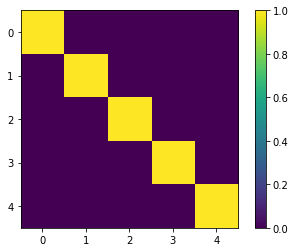

In [3]:
dim_system = 5

# alpha should have the same dimension than P_syn
# Strategy functions
def alpha_syn(t):return(np.ones([dim_system, dim_system])) #mobility in node

#random symetric matrix
#P_syn = np.random.rand(5,5) # 5x5 matrix
#P_syn = (P_syn + P_syn.T)/2

# disconnected matrix, only diagonal values, ie only mobility in nodes
P_syn = np.diag(np.repeat(1,dim_system))

# two connected nodes matrix
#P_syn = np.diag(np.repeat(0.5,5))
#P_syn[0][2] = 0.5
#P_syn[2][0] = 0.5

plt.imshow(P_syn)
plt.colorbar()
plt.show()

### States of the synthetic system

In [4]:
#initial conditions
t  = np.linspace(0, 400, 4000) # time grid, (from, to, number_of_step)

#define initial states vector
S0 = np.full(dim_system,500) #10 dim array with 500 persons per square
E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

I0[0] = 50 #50 initial infected persons in node 0

N = S0+E0+I0+R0

# variables
beta  = 0.2
sigma = 0.1
gamma = 0.1
mu    = 1
#epsilon = 0.3 #from literature
epsilon = 1.0
ks = 1.0
ki = 1

#Init variables
tr=np.arange(401) #Days
h=0.1

print(N)

[550. 500. 500. 500. 500.]


## Run synthetic system

In [5]:
importlib.reload(sys.modules["class_SEIR"]) # to load class when it changes on disk
from class_SEIR import SEIR

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

test_syn.integr(min(tr),max(tr),0.1, False)

print(N)

Scikit couldn't be imported. Using RK4 instead
[550. 500. 500. 500. 500.]


# Quality assessment

## 1 Constant number of population N

Prove that total population remains constant during simulation. A straight line shows that N is constant in time.

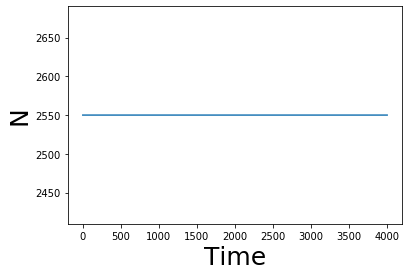

In [6]:
sim_time = 4000

N_total = []
for i in range(sim_time):
    N_total.append(np.sum(test_syn.S[:,i]) + np.sum(test_syn.E[:,i]) + np.sum(test_syn.I[:,i]) +np.sum(test_syn.R[:,i]))

plt.plot(N_total)
plt.ylabel("N", size=25)
plt.xlabel("Time", size=25)
plt.show()

## 2 General states of the system

Behavior of the sum of all the states of the system. We expect to observe a soft behavior.

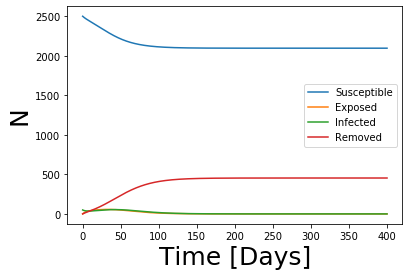

In [7]:
sim_time = 4000

S_total = []
E_total = []
I_total = []
R_total = []
for i in range(sim_time):
    S_total.append(np.sum(test_syn.S[:,i]))
    E_total.append(np.sum(test_syn.E[:,i]))
    I_total.append(np.sum(test_syn.I[:,i]))
    R_total.append(np.sum(test_syn.R[:,i]))
    
plt.plot(t,S_total, label="Susceptible")
plt.plot(t,E_total, label="Exposed")
plt.plot(t,I_total, label="Infected")
plt.plot(t,R_total, label="Removed")
plt.legend()
plt.ylabel("N", size=25)
plt.xlabel("Time [Days]", size=25)
plt.show()

## 3 All states of the system

We expect to see a soft behavior in all the curves. In this assessment some mistake will be easily identify.

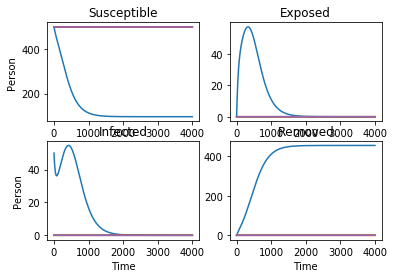

In [8]:
plot_all_states(test_syn.S, test_syn.E, test_syn.I, test_syn.R, dim_system)

## 4 Sensibility to parameters

Scikit couldn't be imported. Using RK4 instead
beta = 0.0


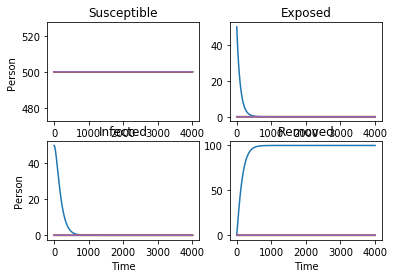

Scikit couldn't be imported. Using RK4 instead
beta = 0.3333333333333333


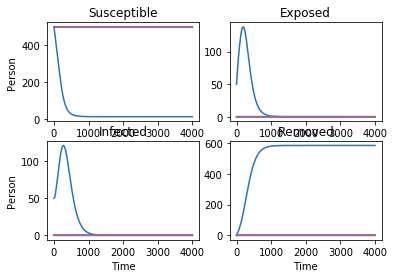

Scikit couldn't be imported. Using RK4 instead
beta = 0.6666666666666666


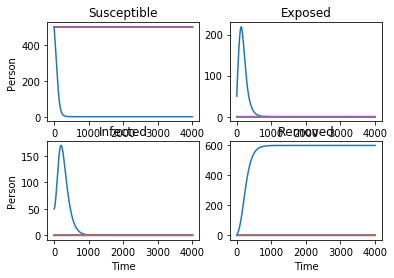

Scikit couldn't be imported. Using RK4 instead
beta = 1.0


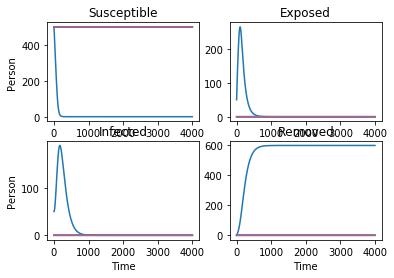

Scikit couldn't be imported. Using RK4 instead
beta = 1.3333333333333333


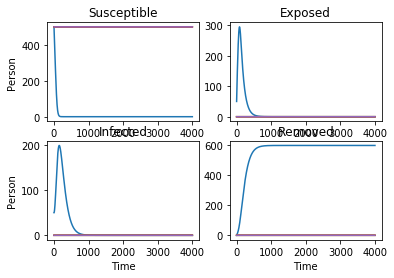

Scikit couldn't be imported. Using RK4 instead
beta = 1.6666666666666665


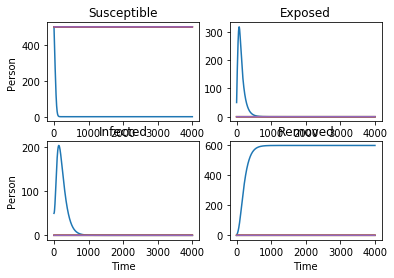

Scikit couldn't be imported. Using RK4 instead
beta = 2.0


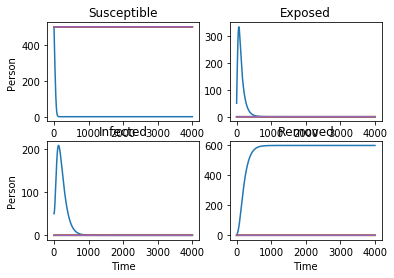

Scikit couldn't be imported. Using RK4 instead
beta = 2.333333333333333


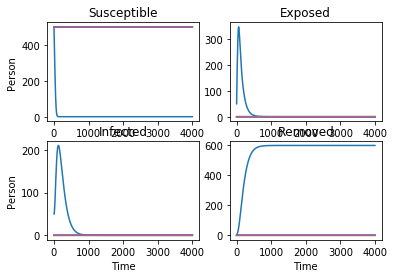

Scikit couldn't be imported. Using RK4 instead
beta = 2.6666666666666665


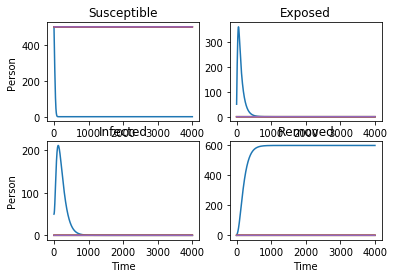

Scikit couldn't be imported. Using RK4 instead
beta = 3.0


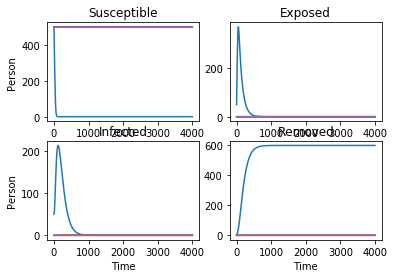

In [9]:
#change beta from 0 to 3.
for beta in np.linspace(0,3,10):
    test_QA = SEIR(P_syn,alpha_syn, S0,E0,I0,R0,beta, sigma, gamma, mu, epsilon, ks, ki)
    test_QA.integr(min(tr),max(tr),0.1,True)
    
    print("beta = {}".format(beta))
    plot_all_states(test_QA.S, test_QA.E, test_QA.I, test_QA.R, dim_system)

#reset system

## 5 Same dimension of parameters

The dimension of the mobility matrix $P$ should have the same dimension than $\alpha(t)$ and ...

In [10]:
if np.shape(P_syn)==np.shape(alpha_syn(0)):
    print("compatible variables (P_syn and alpha_syn)")
else:
    print("dimension error in variables")

compatible variables (P_syn and alpha_syn)


## 6 Running only one disconnected node

We should see dynamics only in one node, the other should keep their states constant. Infected are shown.

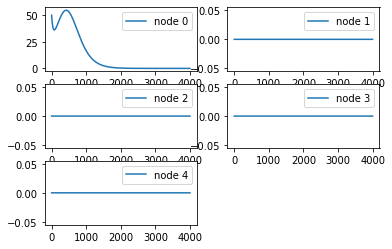

In [11]:
for i in range(len(P_syn)):
    plt.subplot(3,2,i+1)
    plt.plot(test_syn.I[i], label="node {}".format(i))
    plt.legend()
plt.show()

## 7 Comparison with one node dynamics

We run the simulation only in one node with not connectivity to others node and compare with a simple SEIR model.

[500, 0.0, 50.0, 0.0]
550.0


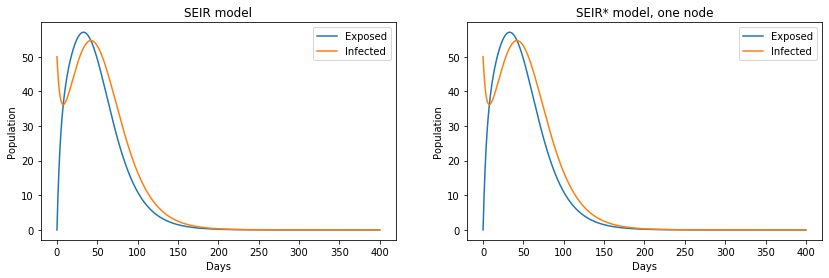

Total infected people: SEIR = 454.09544876013916, SEIR* = 454.0954481807374
Percentage infected people: SEIR = 90.81908975202784, SEIR* = 90.81908963614747
Maximum number of infected SEIR = 54.66755207893756, SEIR* = 54.667533460183684
Days in wich infected are maximum SEIR = 420, SEIR* = 420


In [12]:
plt.rcParams["figure.figsize"] = 14, 4
#### multi node matrix ###

#initial conditions
t  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0[0], E0[0], I0[0], R0[0]]  

N = (S0+E0+I0+R0)[0]

# reset beta due to test 4
beta = 0.2

print(y0)
print(N)
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

# plot results
plt.subplot(1,2,1)
#plt.plot(t, S_single, label='Susceptible')
#plt.plot(t, E_single, label='Exposed')
plt.plot(t,E_single, label='Exposed')
plt.plot(t,I_single, label='Infected')
#plt.plot(t, R_single, label='Removed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('SEIR model')
plt.legend(loc=0)

#Multi nodes system
plt.subplot(1,2,2)
#plt.plot(t, test_syn.S[0], label='Susceptible')
plt.plot(t,test_syn.E[0][:-1], label='Exposed')
plt.plot(t,test_syn.I[0][:-1], label='Infected')
#plt.plot(test_syn.R[0], label='Removed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.title("SEIR* model, one node")
plt.legend(loc=0)
plt.show()

print("Total infected people: SEIR = {}, SEIR* = {}".format( R_single[-1], test_syn.R[0][-1]))
print("Percentage infected people: SEIR = {}, SEIR* = {}".format(R_single[-1] *100/S0[0], test_syn.R[0][-1] *100/S0[0]))
print("Maximum number of infected SEIR = {}, SEIR* = {}".format( I_single.max(),test_syn.I[0].max()))
print("Days in wich infected are maximum SEIR = {}, SEIR* = {}".format(I_single.argmax(),test_syn.I[0].argmax()))

## 8 Comparison of 2 nodes dynamics with high mobility with a SEIR system

We start in each node with 500 susceptible and 50 infected person for the SEIR* system. For the SEIR system we start with a total of 500 susceptible and 50 infected. The total population of the SEIR* system is the double of the SEIR system.

Importante: LA SUMA DE CADA COLUMNA O FILA DEBE SUMAR 1, PORQUE ESA ES LA PROPORCION DE PERSONAS QUE INTERACTUAN. EJ: 0.5 SE QUEDA EN EL NODO, Y OTRO 0.5 SALE DEL NODO. Al NODO PUEDE ENTRAR MAS DE 1.0 DE PERSONAS. DOCUMENTAR BIEN ESTO.

Scikit couldn't be imported. Using RK4 instead
[500, 0.0, 50.0, 0.0]
550.0


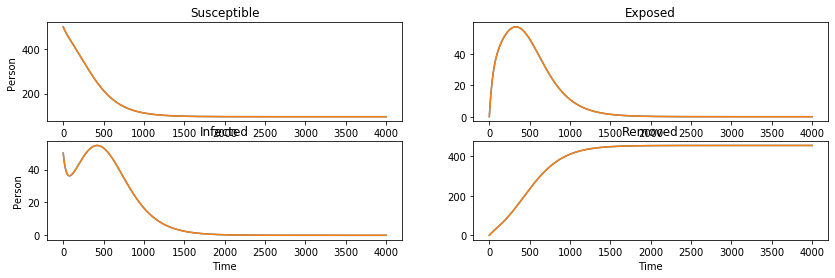

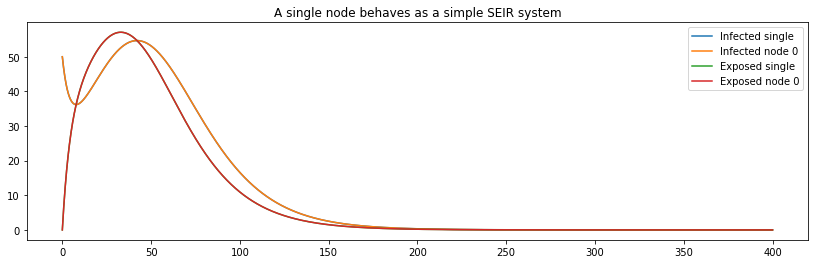

In [13]:
#### two connected nodes matrix ###

#P_syn = np.diag(np.repeat(0.5,2))
P_syn = np.diag(np.repeat(0.0,2))
P_syn[0][1] = 1#0.5
P_syn[1][0] = 1#0.5

def alpha_syn(t):
    return(np.ones([2,2])) #mobility in node

#initial conditions
t  = np.linspace(0, 400, 4000) # time grid, (from, to, number_of_step)

dim_system = len(P_syn)
#define initial states vector
S0 = np.full(dim_system,500) #500 persons per square
E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

I0[0] = 50 #50 initial infected persons in node 0
I0[1] = 50 #50 initial infected persons in node 1

N = S0+E0+I0+R0

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

test_syn.integr(min(tr),max(tr),0.1, False)

#### One node system ####

#initial conditions
t  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0[0], E0[0], I0[0], R0[0]]  

N = (S0+E0+I0+R0)[0]

print(y0)
print(N)
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

# Plot
plot_all_states(test_syn.S, test_syn.E, test_syn.I, test_syn.R, len(P_syn))
plt.plot(t,I_single, label='Infected single')
plt.plot(t,test_syn.I[0][:-1], label='Infected node 0')

plt.plot(t,E_single, label='Exposed single')
plt.plot(t,test_syn.E[0][:-1], label='Exposed node 0')

plt.title("A single node behaves as a simple SEIR system")
plt.legend()
plt.show()

## 9 Comparison of 2 nodes with a double size SEIR system

We double the size of the SEIR system of point 8, and the system had the same behavior. The total of population is the same for SEIR and SEIR* system. The initial infected per node is the same, the mobility matrix values are 0.5.

Initial condition two node
[500 500] [0. 0.] [20. 80.] [0. 0.]
[520. 580.]
Scikit couldn't be imported. Using RK4 instead
Initial condition one node
[1000, 0.0, 100.0, 0.0]
1100.0


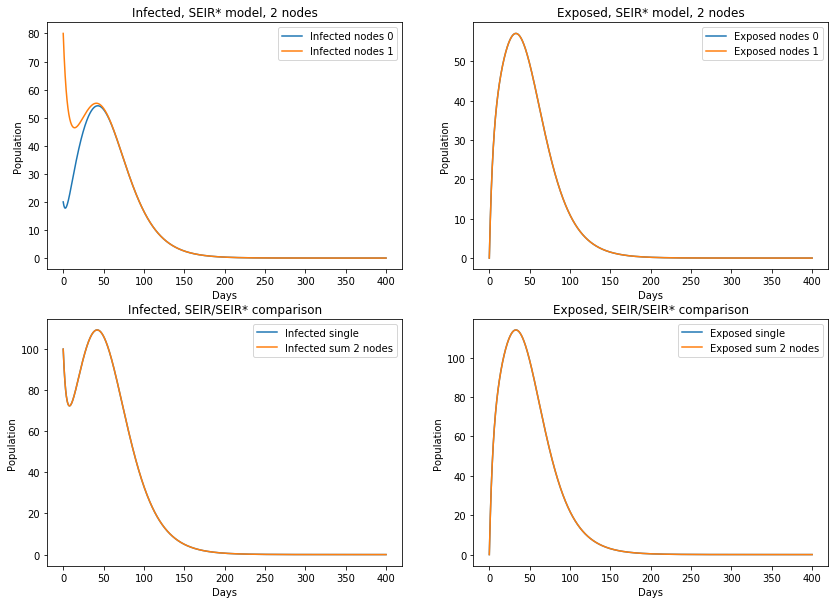

In [14]:
#### two connected nodes matrix ###

P_syn = np.diag(np.repeat(0.5,2))
#P_syn = np.diag(np.repeat(0.0,2))
P_syn[0][1] = 0.5#0.5
P_syn[1][0] = 0.5#0.5

def alpha_syn(t):
    return(np.ones([2,2])) #mobility in node

#initial conditions
t  = np.linspace(0, 400, 4000) # time grid, (from, to, number_of_step)

dim_system = len(P_syn)
#define initial states vector
S0 = np.full(dim_system,500) #500 persons per square
E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

I0[0] = 20 #50 initial infected persons in node 0
I0[1] = 80 #50 initial infected persons in node 1

N = S0+E0+I0+R0

print("Initial condition two node")
print(S0,E0,I0,R0)
print(N)

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

test_syn.integr(min(tr),max(tr),0.1, False)

# sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I0_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += test_syn.S[i]
    E0_sum += test_syn.E[i]
    I0_sum += test_syn.I[i]
    R0_sum += test_syn.R[i]

#### One node system ####
#initial conditions
t  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0.sum(), E0.sum(), I0.sum(), R0.sum()]
N  = (S0.sum()+E0.sum()+I0.sum()+R0.sum())

print("Initial condition one node")
print(y0)
print(N)
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

#plt.title("The sum of 2 nodes behaves as a double size SEIR system")
#plt.title("Nodos 0 and 1 have the same behavior")

plot_comparison(dim_system, test_syn, I_single, E_single, I0_sum, E0_sum)

## 10 Comparison of 2 nodes with a double size SEIR system, different initial infected per node

The total population is the same for SEIR and SEIR* system, but the initial infected number of person per node is different. The result is the same if the mobility matrix is 0.5 in all their values. The number of infected per node must sum 100, in any combination, the main topic here is the 0.5 value of mobility matrix.

Also, if the number of initial infected is the same, the mobility rate could have any value, while the sum of the row is 1.

Initial condition two node
S0  10000.0
I0  100.0
Scikit couldn't be imported. Using RK4 instead
Initial condition one node
[10000.0, 0.0, 100.0, 0.0]
10100.0


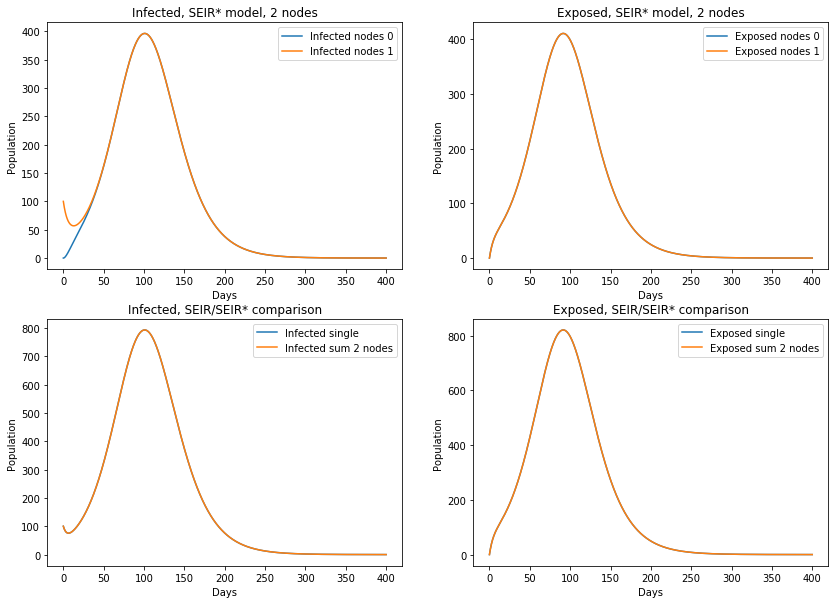

In [15]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 14, 5

#### two connected nodes matrix ###
P_syn = np.random.rand(2,2)

def alpha_syn(t): return(np.ones([2,2])) #mobility in node

full_entropy = True
if full_entropy:
    P_syn[0][1] = 0.5
    P_syn[1][0] = 0.5
    P_syn[1][1] = 0.5
    P_syn[0][0] = 0.5
else:
    
    # case 2,3
    P_syn[0][1] = 0.0
    P_syn[1][0] = 0.5 #0.25
    P_syn[1][1] = 0.5 #0.75
    P_syn[0][0] = 1.0
    
# initial conditions
t  = np.linspace(0, 400, 4000) # time grid, (from, to, number_of_step)

dim_system = len(P_syn)
#define initial states vector
#S0 = np.full(dim_system,500) #500 persons per square
S0 = np.zeros(dim_system)
S0[0] = np.array([5000])
S0[1] = np.array([5000])
E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

I0[0] = 0  #initial infected persons in node 0
I0[1] = 100 #initial infected persons in node 1

N = S0+E0+I0+R0

print("Initial condition two node")
print("S0 ", S0.sum())
print("I0 ", I0.sum())
#print(S0,E0,I0,R0)
#print(N)

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

test_syn.integr(min(tr),max(tr),0.1, False)

# sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I0_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += test_syn.S[i]
    E0_sum += test_syn.E[i]
    I0_sum += test_syn.I[i]
    R0_sum += test_syn.R[i]

#### One node system ####
#initial conditions
t  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0.sum(), E0.sum(), I0.sum(), R0.sum()]
N  = (S0.sum()+E0.sum()+I0.sum()+R0.sum())

print("Initial condition one node")
print(y0)
print(N)
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

#plt.title("The sum of 2 nodes behaves as a double size SEIR system, with different initial infected per node")
plot_comparison(dim_system, test_syn, I_single, E_single, I0_sum, E0_sum)

## 11 Check infected traveling

We will check if infected people are traveling. All people from node 1 move to node 0, and people from 0 stay at their node. If infected travel, there will be infection in node 0. If infected don't travel, so the infected curve should decay with not increase at all.

Initial condition two node
S0  10000.0
I0  100.0
Scikit couldn't be imported. Using RK4 instead
Initial condition one node
[10000.0, 0.0, 100.0, 0.0]
10100.0


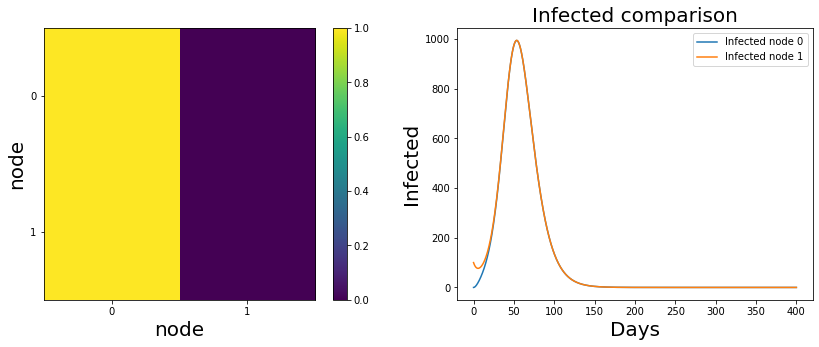

In [16]:
plt.rcParams["figure.figsize"] = 14, 5

dim_system = 2

#### two connected nodes matrix ###
P_syn = np.random.rand(dim_system, dim_system)

def alpha_syn(t):return(np.ones([dim_system,dim_system])) #mobility in node

full_entropy = False
if full_entropy:
    P_syn[0][1] = 0.5
    P_syn[1][0] = 0.5
    P_syn[1][1] = 0.5
    P_syn[0][0] = 0.5
else:
    P_syn[0][1] = 0.0
    P_syn[1][0] = 1.0 
    P_syn[1][1] = 0.0
    P_syn[0][0] = 1.0

    
# initial conditions
t  = np.linspace(0, 400, 4000) # time grid, (from, to, number_of_step)

S0 = np.zeros(dim_system)
S0[0] = np.array([5000])
S0[1] = np.array([5000])
E0 = np.zeros(dim_system)
I0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

I0[0] = 0   #initial infected persons in node 0
I0[1] = 100 #initial infected persons in node 1

N = S0+E0+I0+R0

print("Initial condition two node")
print("S0 ", S0.sum())
print("I0 ", I0.sum())
#print(S0,E0,I0,R0)
#print(N)

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

test_syn.integr(min(tr),max(tr),0.1, False)

# sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I0_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += test_syn.S[i]
    E0_sum += test_syn.E[i]
    I0_sum += test_syn.I[i]
    R0_sum += test_syn.R[i]

#### One node system ####
#initial conditions
t  = np.linspace(0, 400., 4000) # time grid, (from, to, number_of_step)
y0 = [S0.sum(), E0.sum(), I0.sum(), R0.sum()]
N  = (S0.sum()+E0.sum()+I0.sum()+R0.sum())

print("Initial condition one node")
print(y0)
print(N)
# solve the ODEs
soln = odeint(model_SEIR, y0, t) # (model, initial_conditions, time_series)

#reshape the output of the solver to plot the states
S_single = soln[:, 0]
E_single = soln[:, 1]
I_single = soln[:, 2]
R_single = soln[:, 3]

plt.subplot(1,2,1)
extent = (0, P_syn.shape[1], P_syn.shape[0], 0)
plt.imshow(P_syn)
plt.xticks([0,1])
plt.yticks([0,1])
plt.ylim(1.5, -0.5)
plt.colorbar()
plt.xlabel('node', size=20)
plt.ylabel('node', size=20)

plt.subplot(1,2,2)
plt.plot(t[:4000], test_syn.I[0][:4000], label='Infected node {}'.format(0))
plt.plot(t[:4000], test_syn.I[1][:4000], label='Infected node {}'.format(1))
plt.xlabel('Days', size=20)
plt.ylabel('Infected', size=20)
plt.title("Infected comparison", size=20)
plt.legend()

plt.show()

## 12 Dividing day in 24 hours

We check if simulate 24 hours is the same that simulate daily. To accomplish this QA we have divided the rates of the disease by 24.

Initial condition 5 nodes
S0  99999.99999999999
I0  10.0
Scikit couldn't be imported. Using RK4 instead
Scikit couldn't be imported. Using RK4 instead


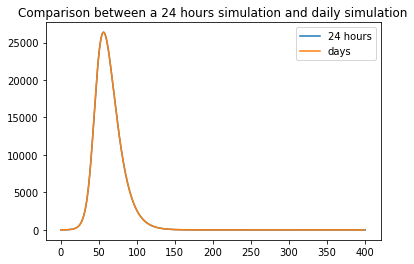

In [12]:
# simulation in DAYS

dim_system = 5

# 5 random connected nodes
P_syn = np.random.rand(dim_system, dim_system)

def alpha_syn(t):return(np.ones([dim_system,dim_system])) #mobility in node

# variables
beta  = 0.3
sigma = 0.1
gamma = 0.1
mu    = 1
epsilon = 1.0
ks = 1.0
ki = 1

total_susceptible = 100000
total_infected    = 10

# random Susceptible vector
S0 = np.random.rand(dim_system)  # uniform random
#S0 = np.random.normal(30000, size = dim_system) # gaussian random
S0 = total_susceptible * S0/S0.sum()

#S0 = np.random.rand(10, 10)
#S0 = block_diag(S0, S0)

# zero values
E0 = np.zeros(dim_system)
R0 = np.zeros(dim_system)

# random infected vector
I0 = np.random.rand(dim_system)
I0 = total_infected * I0/I0.sum()
#I0 =  np.zeros(dim_system)
#I0[0] = 10

print("Initial condition {} nodes".format(dim_system))
print("S0 ",S0.sum())
print("I0 ",I0.sum())

#N = S0+E0+I0+R0 #not necessary, is inside SEIR class

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

#Init variables
#time=np.arange(401) #Days
time=np.linspace(0, 400., 4000)
h=0.1

test_syn.integr(min(time),max(time),0.1, False)

# sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I0_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += test_syn.S[i]
    E0_sum += test_syn.E[i]
    I0_sum += test_syn.I[i]
    R0_sum += test_syn.R[i]

#### simulation in HOURS ###
# variables
beta  = 0.3/24
sigma = 0.1/24
gamma = 0.1/24
mu    = 1
epsilon = 1.0
ks = 1.0
ki = 1

#N = S0+E0+I0+R0 #not necessary, is inside SEIR class

test_syn = SEIR(P_syn,alpha_syn,S0, E0, I0, R0, 
                beta, sigma, gamma, mu, epsilon, ks, ki)

#Init variables
#time24=np.arange(9624) # hours 401*24
time24=np.linspace(0, 9624., 96241) # (9624/0.1)+1=96241
h=0.1

test_syn.integr(min(time24),max(time24),0.1, False)

# sum all states to compare with one node
S0_sum = 0
E0_sum = 0
I024_sum = 0
R0_sum = 0

for i in range(dim_system):
    S0_sum += test_syn.S[i]
    E0_sum += test_syn.E[i]
    I024_sum += test_syn.I[i]
    R0_sum += test_syn.R[i]

plt.plot(time24/24, I024_sum, label="24 hours")
plt.plot(time, I0_sum[:-1], label="days")
plt.title("Comparison between a 24 hours simulation and daily simulation")
plt.legend()
plt.show()